# Uplift Modeling

In [15]:
import numpy as np 
import pandas as pd 
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import warnings 

warnings.filterwarnings('ignore')
%matplotlib inline
plt.rcParams["figure.figsize"] = (20,10)

In [16]:
# Load the dataset
campaign = pd.read_csv('~/uplift_campaign.csv') # NEED FOR CHANGE

Among other things, look at the ratio of how many people actually bought something (conversion10days) and how many people received a marketing incentive (treatment)

In [3]:
campaign.describe(include='all')

,spending10days,conversion10days,zipCode_0,zipCode_1,zipCode_2,zipCode_3,zipCode_4,zipCode_5,zipCode_6,zipCode_7,...,device_ipad,device_iphone,device_mac,device_other,conversionLastWeek,conversionLastMonth,visitLastMonth,visitLastWeek,hoursFromLastVisit,treatment
count,60000.00000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,...,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.00000,60000.000000
mean,9.54018,0.161750,0.094183,0.082933,0.128450,0.088283,0.082967,0.057283,0.042850,0.162883,...,0.056667,0.129733,0.063750,0.126283,0.020267,0.042933,0.173633,0.103150,1.23920,0.500000
std,23.24368,0.368224,0.292086,0.275784,0.334593,0.283709,0.275834,0.232385,0.202521,0.369262,...,0.231207,0.336013,0.244309,0.332171,0.140912,0.202709,0.378797,0.304157,6.26341,0.500004
min,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
25%,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
50%,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.500000
75%,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,1.000000
max,588.99279,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,311.00000,1.000000


# Data partitioning


In [4]:
# Partition the data into training and test set, using 25% of the data for testing 
# We want to stratify on both conversion10days and treatment to keep the distribution between train and testing equal
from sklearn.model_selection import train_test_split
train, test = train_test_split(campaign, test_size=0.25, random_state=0, 
                               stratify=campaign[['conversion10days', 'treatment']])

In [5]:
# Check whether the data has been randomly assigned. This is an important assumptions in uplift modeling and, more generally, experimental designs. To verify a random assignment, we have to check the balance of the A/B indicator. The function checkBalance calculates standardized mean differences along each covariate and tests for conditional independence of the treatment variable and the covariates. In randomized empirical experiments the treatment and control groups should be roughly similar (i.e. balanced) in their distributions of covariates.
# Of course, we would expect the conversion rate to be different between the treatment and control group
train[['conversion10days', 'treatment']].describe()

,conversion10days,treatment
count,45000.000000,45000.000000
mean,0.161756,0.500000
std,0.368231,0.500006
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,0.500000
75%,0.000000,1.000000
max,1.000000,1.000000


In [6]:
test[['conversion10days', 'treatment']].describe()

,conversion10days,treatment
count,15000.000000,15000.000000
mean,0.161733,0.500000
std,0.368218,0.500017
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,0.500000
75%,0.000000,1.000000
max,1.000000,1.000000


# Data Validity

In [7]:
X = campaign.columns.drop(['conversion10days', 'treatment'])
features = campaign[X]
treatment_group = campaign[campaign.treatment == 1]
treatment_group = treatment_group[X]
control_group =  campaign[campaign.treatment == 0]
control_group = control_group[X]
agg_operations = {feature: ['mean', 'std'] for feature in features}
t_means  = treatment_group.agg(agg_operations)
c_means = control_group.agg(agg_operations)

Check whether the data has been randomly assigned. This is an important assumptions in uplift modeling and, more generally, experimental designs. To verify a random assignment, we have to check the balance of the A/B indicator. We will calculate standardized mean differences along each covariate and tests for conditional independence of the treatment variable and the covariates. In randomized empirical experiments the treatment and control groups 
should be roughly similar (i.e. balanced) in their distributions of covariates. <br>
Of course, we would expect the conversion rate to be different between the treatment and control group


In [8]:
import scipy.stats as stats
pscores = pd.DataFrame(columns=features.columns)

for i in features.columns:
            p_score = stats.ttest_ind(
            a=treatment_group[i],
            b=control_group[i],equal_var=False)
            pscores[i] = p_score
            
pscores

,spending10days,zipCode_0,zipCode_1,zipCode_2,zipCode_3,zipCode_4,zipCode_5,zipCode_6,zipCode_7,zipCode_Foreign,...,device_windows,device_ipad,device_iphone,device_mac,device_other,conversionLastWeek,conversionLastMonth,visitLastMonth,visitLastWeek,hoursFromLastVisit
0,1.304982e+01,-0.601007,1.006618,-0.671071,0.705092,0.266407,1.036498,0.020158,0.011056,-1.349682,...,-0.083273,-0.776919,0.996283,1.487233,-1.487141,-1.506550,-0.845864,-0.387987,-0.442932,-0.451042
1,7.207899e-39,0.547837,0.314122,0.502178,0.480756,0.789927,0.299974,0.983917,0.991179,0.177123,...,0.933634,0.437210,0.319117,0.136958,0.136983,0.131931,0.397632,0.698027,0.657816,0.651961


In [9]:
table_one = campaign.groupby(campaign.treatment).agg(agg_operations)

table_one.head()

spending10days            zipCode_0           zipCode_1            \
                    mean        std      mean       std      mean       std   
treatment                                                                     
0               8.303601  21.852486  0.094900  0.293082  0.081800  0.274064   
1              10.776759  24.494199  0.093467  0.291090  0.084067  0.277492   

          zipCode_2           zipCode_3            ... conversionLastWeek  \
               mean       std      mean       std  ...               mean   
treatment                                          ...                      
0          0.129367  0.335611  0.087467  0.282522  ...           0.021133   
1          0.127533  0.333575  0.089100  0.284893  ...           0.019400   

                    conversionLastMonth           visitLastMonth            \
                std                mean       std           mean       std   
treatment                                                                    
0          0.143831            0.043633  0.204281       0.174233  0.379316   
1          0.137929            0.042233  0.201124       0.173033  0.378282   

          visitLastWeek           hoursFromLastVisit            
                   mean       std               mean       std  
treatment                                                       
0                0.1037  0.304876           1.250733  6.240067  
1                0.1026  0.303441           1.227667  6.286749  

[2 rows x 48 columns]

In [10]:
def compute_table_one_smd(table_one: pd.DataFrame, round_digits: int=4) -> pd.DataFrame:
    feature_smds = []
    for feature in features.columns:
        feature_table_one = table_one[feature].values
        neg_mean = feature_table_one[0, 0]
        neg_std = feature_table_one[0, 1]
        pos_mean = feature_table_one[1, 0]
        pos_std = feature_table_one[1, 1]

        smd = (pos_mean - neg_mean) / np.sqrt((pos_std ** 2 + neg_std ** 2) / 2)
        smd = round(abs(smd), round_digits)
        feature_smds.append(smd)

    return pd.DataFrame({'features': features.columns, 'smd': feature_smds})


table_one_smd = compute_table_one_smd(table_one)
table_one_smd 

,features,smd
0,spending10days,0.1066
1,zipCode_0,0.0049
2,zipCode_1,0.0082
3,zipCode_2,0.0055
4,zipCode_3,0.0058
5,zipCode_4,0.0022
6,zipCode_5,0.0085
7,zipCode_6,0.0002
8,zipCode_7,0.0001
9,zipCode_Foreign,0.0110


In [11]:
checkBalance = pd.DataFrame()
checkBalance['mean T=0'] = c_means.values[0, :]
checkBalance['mean T=1'] = t_means.values[0, :]
checkBalance['smd'] = table_one_smd.smd.values
checkBalance['pvalue'] = pscores.loc[1 , : ].values   #subset to only get p-value of the computed table
checkBalance.index = features.columns
checkBalance
#spending10days missing here

,mean T=0,mean T=1,smd,pvalue
spending10days,8.303601,10.776759,0.1066,7.207899e-39
zipCode_0,0.094900,0.093467,0.0049,5.478374e-01
zipCode_1,0.081800,0.084067,0.0082,3.141224e-01
zipCode_2,0.129367,0.127533,0.0055,5.021781e-01
zipCode_3,0.087467,0.089100,0.0058,4.807558e-01
zipCode_4,0.082667,0.083267,0.0022,7.899267e-01
zipCode_5,0.056300,0.058267,0.0085,2.999742e-01
zipCode_6,0.042833,0.042867,0.0002,9.839172e-01
zipCode_7,0.162867,0.162900,0.0001,9.911791e-01
zipCode_Foreign,0.193333,0.189000,0.0110,1.771231e-01


In [17]:
#overall pvalue "chisquare test

from scipy.stats import chisquare
chisquare(campaign, axis=None)

Power_divergenceResult(statistic=75982051.6668006, pvalue=0.0)

### Alternative with rpy2

install rpy2 using


MacOS commonly throws an error message. 
The solution I found: 
https://stackoverflow.com/questions/52361732/installing-rpy2-on-macos

To do this, you will need to install gcc. If you do not have it installed yet, it is possible through this website:

https://mkyong.com/mac/how-to-install-gcc-compiler-on-mac-os-x/


In [33]:
import rpy2.robjects as robjects
import rpy2.robjects.packages as rpackages
from rpy2.robjects.vectors import StrVector

# ensure uplift package is installed, this code can be edited for any other package 
packageNames = ('uplift')
utils = rpackages.importr('utils')
utils.chooseCRANmirror(ind=1)

packnames_to_install = [x for x in packageNames if not rpackages.isinstalled(x)]

if len(packnames_to_install) > 0:
    utils.install_packages(StrVector(packnames_to_install))

In [18]:
# import  uplift package from r
uplift = rpackages.importr('uplift') 
# for this package to work we need to convert our data 
from rpy2.robjects import pandas2ri
pandas2ri.activate()
from rpy2.robjects.conversion import localconverter

with localconverter(robjects.default_converter + pandas2ri.converter):
  campaign_r = robjects.conversion.py2rpy(campaign)

In [19]:
cb = uplift.checkBalance(robjects.Formula('treatment~.-conversion10days'), data = campaign_r, report = robjects.r('list("adj.means", "adj.mean.diffs", "p.values", "chisquare.test")'))
print(cb)

                    strata     unstrat                                
                    stat   treatment=0 treatment=1  adj.diff          
vars                                                                  
spending10days               8.30e+00    1.08e+01  2.47e+00  ***      
zipCode_0                    9.49e-02    9.35e-02  -1.43e-03          
zipCode_1                    8.18e-02    8.41e-02  2.27e-03           
zipCode_2                    1.29e-01    1.28e-01  -1.83e-03          
zipCode_3                    8.75e-02    8.91e-02  1.63e-03           
zipCode_4                    8.27e-02    8.33e-02  6.00e-04           
zipCode_5                    5.63e-02    5.83e-02  1.97e-03           
zipCode_6                    4.28e-02    4.29e-02  3.33e-05           
zipCode_7                    1.63e-01    1.63e-01  3.33e-05           
zipCode_Foreign              1.93e-01    1.89e-01  -4.33e-03          
abortedPurchase              2.74e-02    2.76e-02  1.67e-04           
produc

In [24]:
cbresultsarray= cb.rx2('results') # extract array, some info lost in conversion which is why we add index and column names prior
cbresults = pd.DataFrame(index=campaign.columns.drop(['treatment', 'conversion10days']), columns=[['treatment=0', 'treatment=1', 'adj. diff', 'p']])  # 1st row as the column names


In [27]:
temp = 0
for i in cbresults.columns:
    cbresults[i] = cbresultsarray[:, temp]
    temp = temp +1
print(cbresults.round(2))

                    treatment=0 treatment=1 adj. diff     p
spending10days             8.30       10.78      2.47  0.00
zipCode_0                  0.09        0.09     -0.00  0.55
zipCode_1                  0.08        0.08      0.00  0.31
zipCode_2                  0.13        0.13     -0.00  0.50
zipCode_3                  0.09        0.09      0.00  0.48
zipCode_4                  0.08        0.08      0.00  0.79
zipCode_5                  0.06        0.06      0.00  0.30
zipCode_6                  0.04        0.04      0.00  0.98
zipCode_7                  0.16        0.16      0.00  0.99
zipCode_Foreign            0.19        0.19     -0.00  0.18
abortedPurchase            0.03        0.03      0.00  0.90
productsInBasket           0.05        0.05      0.00  1.00
logOfVisitFrequency        0.01        0.01      0.00  0.62
logTotalSpending           0.15        0.14     -0.00  0.62
device_windows             0.40        0.40     -0.00  0.93
device_ipad                0.06        0

In [32]:
print(cb.rx2('overall'))

          chisquare    df       p.value
unstrat  187.388697  24.0  2.820402e-27


# Average treatment Effect (ATE)


In [13]:
experiment = pd.crosstab(campaign['treatment'], campaign['conversion10days'], rownames=['Treatment'], colnames=['Conversion'], margins=True)
experiment

Conversion,0,1,All
Treatment,,,
0,25717,4283,30000
1,24578,5422,30000
All,50295,9705,60000


The ATE is the outcome difference between the groups, assuming that individuals in each group are similar which is plausible because of the random sampling

In [14]:
# 5422/30000 - 4283/30000
(experiment.iloc[1].iloc[1]/experiment.iloc[0].iloc[2]) - (experiment.iloc[0].iloc[1]/experiment.iloc[0].iloc[2])


0.037966666666666676

In [15]:
means_spending= campaign[['spending10days', 'treatment']].groupby('treatment').mean()
means_spending

,spending10days
treatment,
0,8.303601
1,10.776759


In [16]:
# 10.8-8.3
ATE_spending = means_spending.iloc[1]-means_spending.iloc[0];
ATE_spending

spending10days    2.473158
dtype: float64

# Difference in conditional means / Two-model approach 

In [17]:
# treatment effect in group 'conversion last month'
means_twomodel= campaign[['spending10days', 'treatment',  'conversionLastMonth']].groupby(['treatment', 'conversionLastMonth'], as_index=False).mean()
means_twomodel

,treatment,conversionLastMonth,spending10days
0,0,0,8.103820
1,0,1,12.682443
2,1,0,10.212262
3,1,1,23.578412


In [18]:
# 23.6 - 12.7
print('The treatment effect is:')
means_twomodel.iloc[3].iloc[2]-means_twomodel.iloc[1].iloc[2]

The treatment effect is:


10.895968680581323

In [19]:
print('The treatment effect in group \'no conversion last month\' is:')
means_twomodel.iloc[2].iloc[2]-means_twomodel.iloc[0].iloc[2]

The treatment effect in group 'no conversion last month' is:


2.108441637598677

The coupon seems to have a bigger effect on recent buyers!

In [20]:
# create list with column names for X and y and T
X = train.columns.drop(['treatment', 'spending10days', 'conversion10days']) # drop variables to exclude from model building
y = 'spending10days'
T = 'treatment'

In [21]:
from sklearn.linear_model import LinearRegression
from sklearn import metrics
import pickle
regressor = LinearRegression()  

# use splitted data for control and treatment group for regression to control for all variables by estimating conditional means

regressor.fit(train.query('treatment==1')[X], train.query('treatment==1')[y]) #training the algorithm
y_predT = regressor.predict(test[X]) # prediction on the test set

treatment_LM = pickle.dumps(regressor) 


#repeat process for  control group data

regressor.fit(train.query('treatment==0')[X], train.query('treatment==0')[y]) #saving model for later DRTO
y_predC = regressor.predict(test[X])

control_LM = pickle.dumps(regressor) 

In [22]:
pred = pd.DataFrame(index=test.index) #create a dataframe to store results
pred['twomodel'] =  (y_predT) - (y_predC) #subtract both predictions from another
np.mean(pred.twomodel)

2.409921459803219

# Outcome Transformation

In [23]:
train_spending_TO = train['spending10days']*train['treatment']/0.5 - (1-train['treatment'])*train['spending10days']/0.5
test_spending_TO = test['spending10days']*test['treatment']/0.5 - (1-test['treatment'])*test['spending10days']/0.5

print(np.mean(train_spending_TO))

2.4507018164052146


The transformed outcome has the same expected value as the ATE, but more variance.

<br> 
# Transformed outcome regression


In [24]:
regressor.fit(train[X], train_spending_TO) #train model on transformed outcome 
pred['reg_TO'] = regressor.predict(test[X])
pred

,twomodel,reg_TO
3282,0.982414,1.576969
42224,6.565176,5.929089
58147,1.868552,1.908265
10806,2.308072,2.269448
18682,-2.816984,-2.530008
...,...,...
32737,1.202406,1.533991
13214,1.196218,1.742744
35332,2.880666,2.644643
17257,1.202406,1.533991


In [25]:
# edit data for casual ml 

train['treatment_numeric'] = train['treatment'] # save a copy of the numeric vector for later  
train.treatment[train.treatment == 0] = 'control' ; #save treatment and control group as strings
train.treatment[train.treatment == 1] = 'treatment';

In [26]:
from causalml.inference.tree import UpliftTreeClassifier, UpliftRandomForestClassifier
from causalml.inference.tree import uplift_tree_string, uplift_tree_plot

uplift_RF = UpliftRandomForestClassifier(control_name='control')

uplift_RF.fit(train[X].values,
                 treatment=train[T].values,
                 y=train[y].values) ;

In [27]:
pred['Causal_RF'] = uplift_RF.predict(test[X].values).ravel() 
# .ravel() extracts the values from the numpy array so it can be loaded into the dataframe

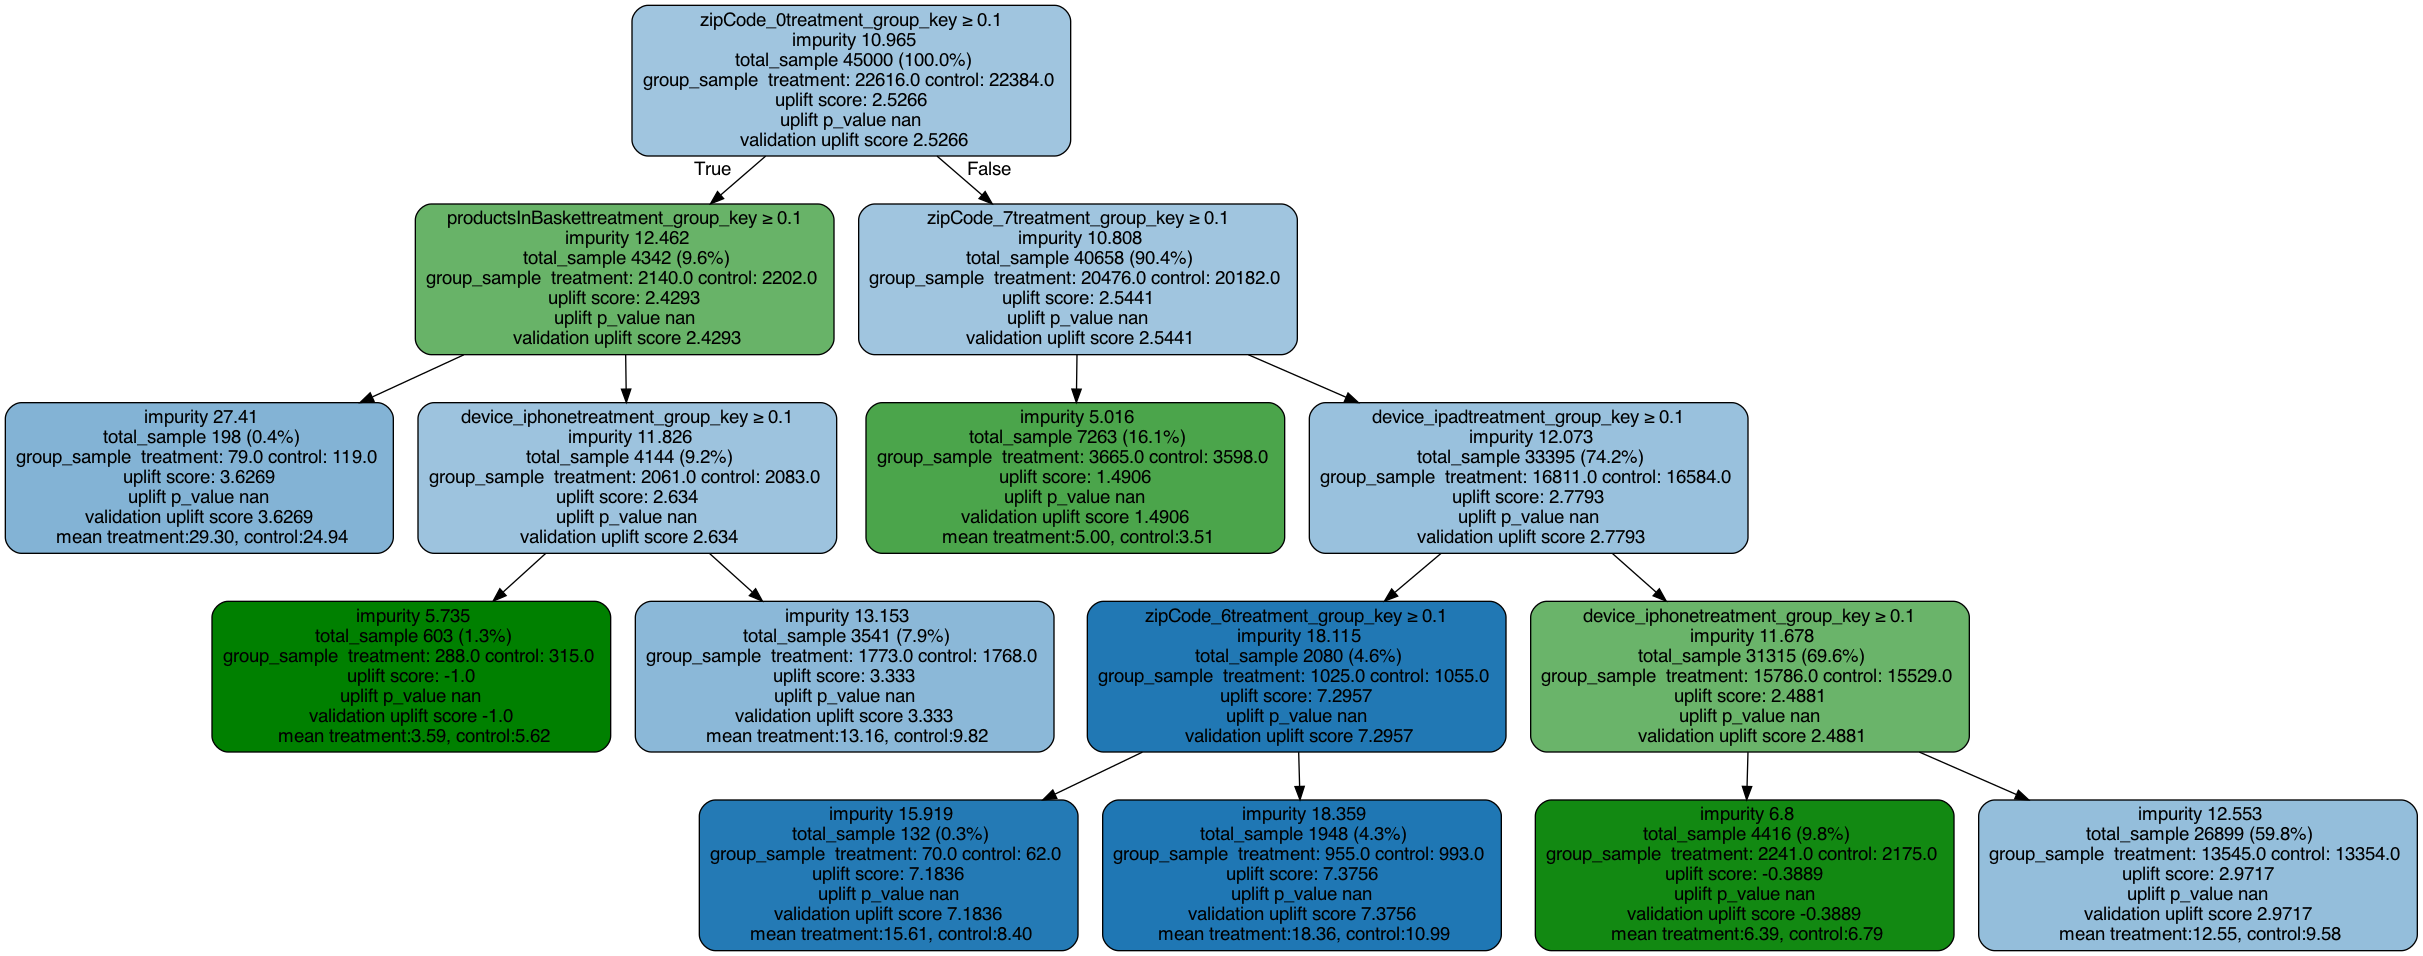

In [28]:
from IPython.display import Image
uplift_tree = uplift_RF.uplift_forest[0]
# Plot uplift tree (single tree)
graph = uplift_tree_plot(uplift_tree.fitted_uplift_tree,X)
Image(graph.create_png())

# Performance Assessment for Uplift Models

In [29]:
# Analyze the predicted values
np.mean(pred)

twomodel     2.409921
reg_TO       2.451557
Causal_RF    2.480962
dtype: float64

The causal forest is not in line with the other models and the ATE. <br>
Let's check what the models estimate on the individual level.

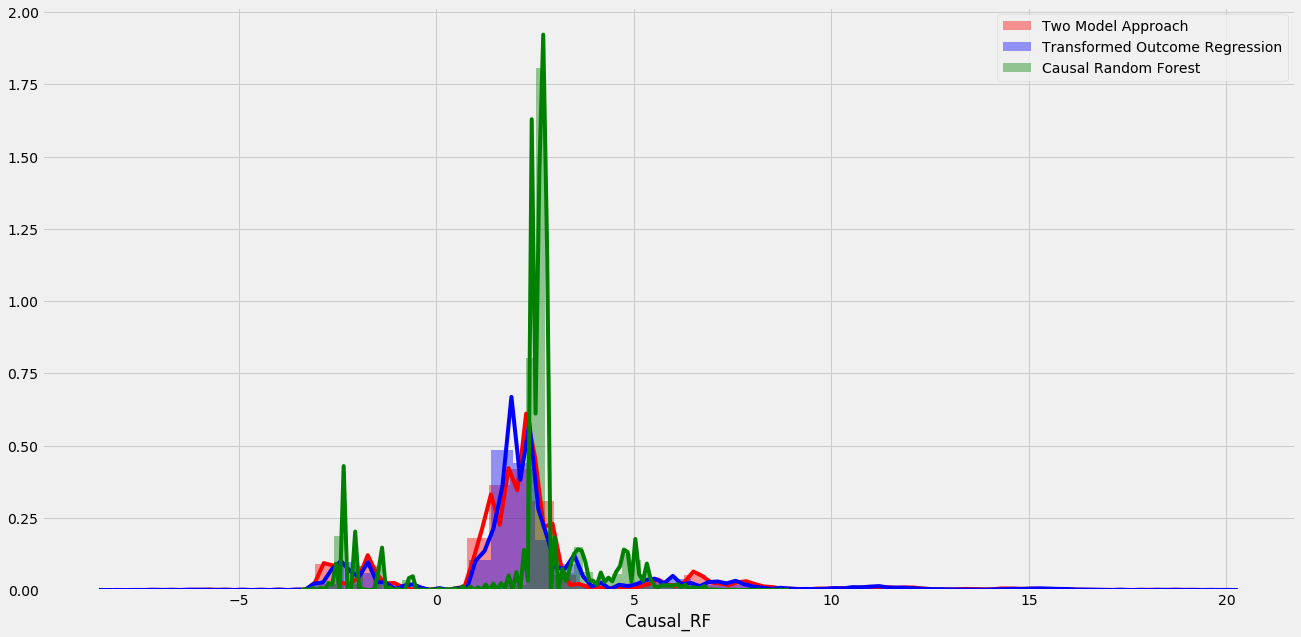

In [30]:
import seaborn as sns
sns.distplot(pred['twomodel'], label="Two Model Approach", color='red')
sns.distplot(pred['reg_TO'], label= 'Transformed Outcome Regression', color='blue')
sns.distplot(pred['Causal_RF'], label = 'Causal Random Forest',  color='green')
plt.legend() ;

There seem to be many cases where the treatment decreases conversion!
<br>
# Transformed Outcome Loss

In [31]:
# the lower the better

for model in pred.columns:
    print(model)
    print(np.mean((test_spending_TO - pred[model]).pow(2)))
    print('')

twomodel
2544.884022832343

reg_TO
2545.4239927756594

Causal_RF
2546.335452283866



# Qini score

Calculate the Qini for each model. <br>
The higher the better!

In [32]:
import matplotlib.pyplot as plt
import scikitplot as skplt
from sklift.metrics import qini_auc_score, uplift_auc_score, uplift_at_k
from sklift.viz import plot_uplift_preds, plot_uplift_qini_curves

for model in pred.columns:
        temp = qini_auc_score(y_true=test[y], uplift=pred[model], treatment=test[T])
        print(model)
        print(temp)
        print(" ")

twomodel
226184490.5937103
 
reg_TO
233567721.3162769
 
Causal_RF
206556320.67256132
 


# Qini and Uplift Curve 

twomodel
reg_TO
Causal_RF


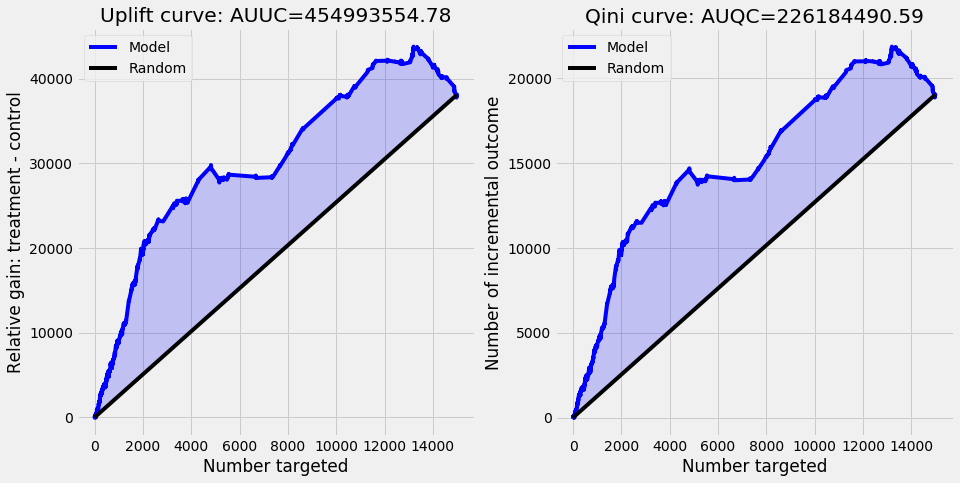

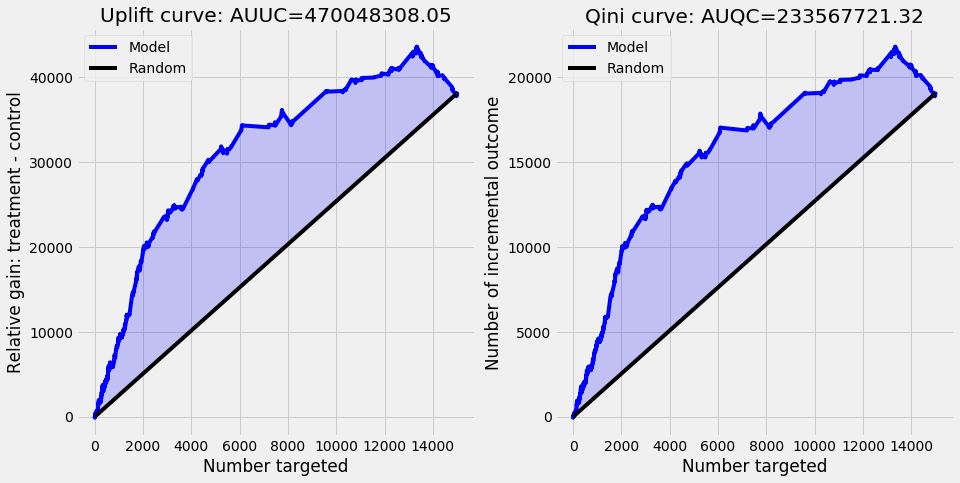

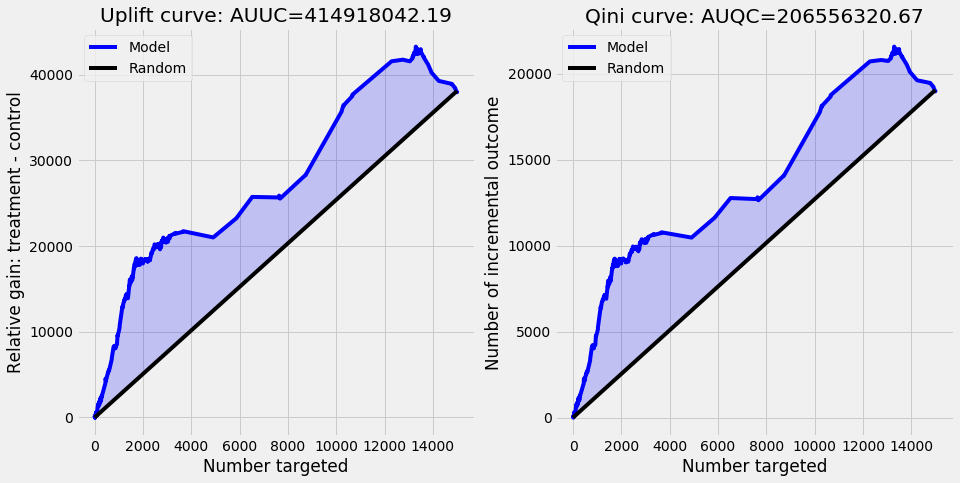

In [33]:
for model in pred.columns:
    
    print(model)
    plot_uplift_qini_curves(y_true=test[y], uplift=pred[model], treatment=test[T])

# Bonus: Qini explanation
Equivalent to the standard model lift, we can calculate the uplift for the sample deciles based on the model score.
<br> <br>
Sort the observation by their estimates. <br>
People with a higher effect are treated earlier.

In [34]:
qini_data = pd.concat([test[['spending10days', 'conversion10days', 'treatment']], pred['Causal_RF']], axis=1,  names=['spending10days', 'conversion10days', 'treatment', 'effect_estimate'])
qini_data = qini_data.rename(columns={'Causal_RF': 'effect_estimate'})
qini_data = qini_data.sort_values(by='effect_estimate', ascending=False)
qini_data

,spending10days,conversion10days,treatment,effect_estimate
29373,63.797775,1,1,8.813965
49736,57.662964,1,0,8.461008
48586,0.000000,0,0,8.159610
30243,0.000000,0,0,8.159610
5439,0.000000,0,1,7.982515
...,...,...,...,...
9722,0.000000,0,1,-2.661426
48347,0.000000,0,0,-3.093876
32102,3.210820,1,0,-3.130582
19354,65.657494,1,1,-3.130582


In [35]:
# We cannot calculate the true treatment effect per person, but per group
# Bin the observations into ten groups based on their estimated effect

# mean effect estimate per decile
labels = list(range(1,11))
score_deciles = qini_data.groupby(pd.qcut(qini_data['effect_estimate'], 10, labels=labels))['effect_estimate'].mean()

# create variable with label for each decile
qini_data['decile'] = pd.qcut(qini_data['effect_estimate'], 10, labels=labels)
qini_data

,spending10days,conversion10days,treatment,effect_estimate,decile
29373,63.797775,1,1,8.813965,10
49736,57.662964,1,0,8.461008,10
48586,0.000000,0,0,8.159610,10
30243,0.000000,0,0,8.159610,10
5439,0.000000,0,1,7.982515,10
...,...,...,...,...,...
9722,0.000000,0,1,-2.661426,1
48347,0.000000,0,0,-3.093876,1
32102,3.210820,1,0,-3.130582,1
19354,65.657494,1,1,-3.130582,1


In [36]:
# count of people treated per decile
n_treated_groups = qini_data[['decile', 'treatment']].groupby('decile').sum()
n_treated_groups

,treatment
decile,
1,766
2,1422
3,171
4,787
5,1121
6,301
7,1116
8,328
9,751


In [37]:
n_treated_groups = n_treated_groups[::-1]  # We will later need the list in the order the other way around

# Qini for binary target outcomes

3088758.1922070533


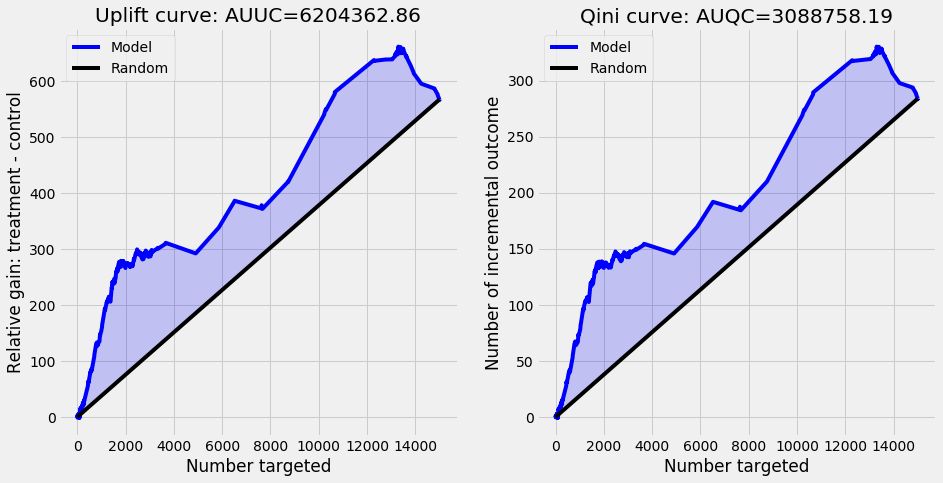

In [38]:
print(qini_auc_score(y_true=test['conversion10days'], uplift=pred["Causal_RF"], treatment=test[T])) #redundant 
plot_uplift_qini_curves(y_true=test['conversion10days'], uplift=pred["Causal_RF"], treatment=test[T]);

In [39]:
treatment_estimate_groups = qini_data[['decile', 'treatment', 'conversion10days', 'spending10days', 'effect_estimate']].groupby(['decile','treatment']).mean() 
treatment_estimate_groups

conversion10days  spending10days  effect_estimate
decile treatment                                                   
1      0                  0.107483        6.344391        -1.995253
       1                  0.052219        3.399884        -1.974417
2      0                  0.093418        5.294377         2.300436
       1                  0.120956        7.183103         2.304055
3      0                  0.138554        8.677943         2.437033
       1                  0.228070       12.161066         2.437021
4      0                  0.160963        9.501160         2.560963
       1                  0.242694       14.634125         2.561358
5      0                  0.162332        9.470745         2.654830
       1                  0.178412       10.676771         2.653034
6      0                  0.090652        5.145189         2.741307
       1                  0.152824        8.212236         2.741482
7      0                  0.158965        9.188380         2.746272
       1                  0.172939        9.982532         2.746263
8      0                  0.167647       10.254526         2.813881
       1                  0.192073       11.424352         2.809058
9      0                  0.169786        9.626109         3.627514
       1                  0.209055       13.170173         3.630423
10     0                  0.185771       11.007965         5.157519
       1                  0.344640       21.520413         5.173641

In [40]:
# As before, we can calculate the average treatment effect in each group
ATE_groups = []
treatment_conversion = treatment_estimate_groups['conversion10days'][1::2].values
control_conversion = treatment_estimate_groups['conversion10days'][0::2].values

for treatment, control in zip(treatment_conversion, control_conversion):
    temp = round(treatment-control, 4)
    ATE_groups.append(temp)
    
ATE_groups
ATE_groups = ATE_groups[::-1] 

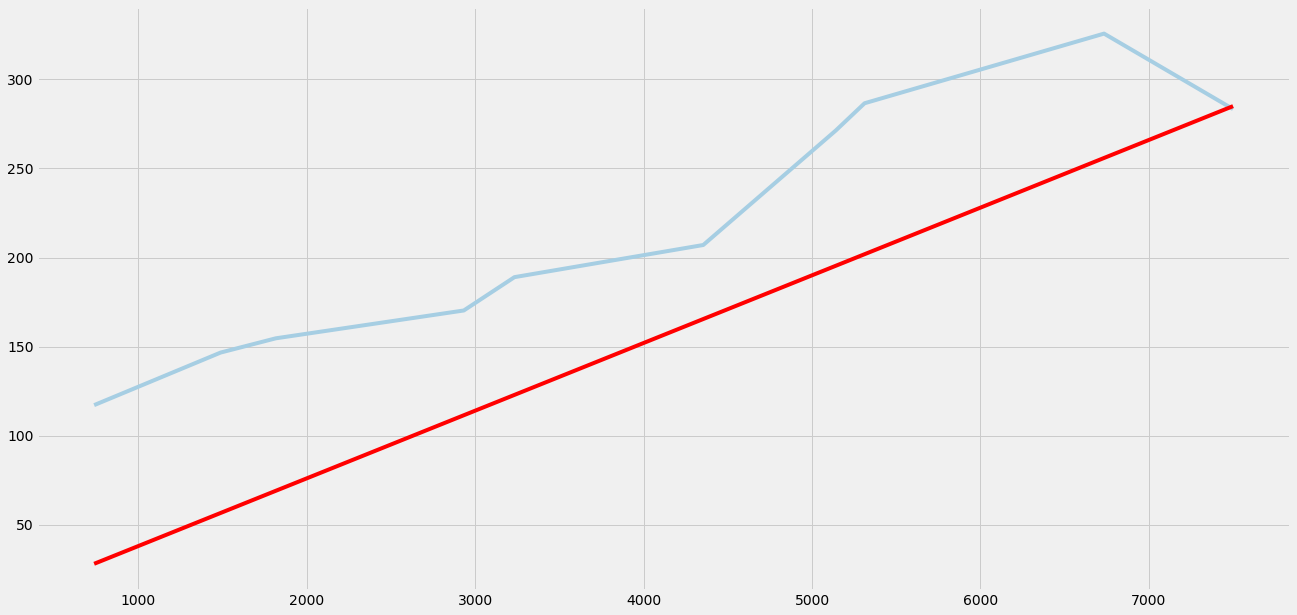

In [41]:
# The incremental gain is the cumulative effect of treating more customers
plt.plot((np.cumsum(n_treated_groups)), (np.cumsum(np.array(n_treated_groups['treatment'])*(ATE_groups))))

# Under random targeting, the treatment effect for each group is the same as the overall treatment effect

ATE_conversion = np.mean(train.query('treatment_numeric==1')['conversion10days'].values) - np.mean(train.query('treatment_numeric==0')['conversion10days'])
plt.plot(np.cumsum(n_treated_groups), np.cumsum(ATE_conversion*n_treated_groups['treatment']), color='red');

The Qini coefficient is the ratio between two areas: <br>
1) The area under the model curve and above the random diagonal <br>
2) The area under the optimal curve and above the random diagonal <br>
Since the area under the optimal curve is constant for all models, the area under the model curve is sufficient
for model comparison.

In [42]:
# As before, we can calculate the average treatment effect in each group
ATE_groups = []
treatment_conversion = treatment_estimate_groups['spending10days'][1::2].values
control_conversion = treatment_estimate_groups['spending10days'][0::2].values

for treatment, control in zip(treatment_conversion, control_conversion):
    temp = round(treatment-control, 4)
    ATE_groups.append(temp)
    
ATE_groups

[-2.9445, 1.8887, 3.4831, 5.133, 1.206, 3.067, 0.7942, 1.1698, 3.5441, 10.5124]

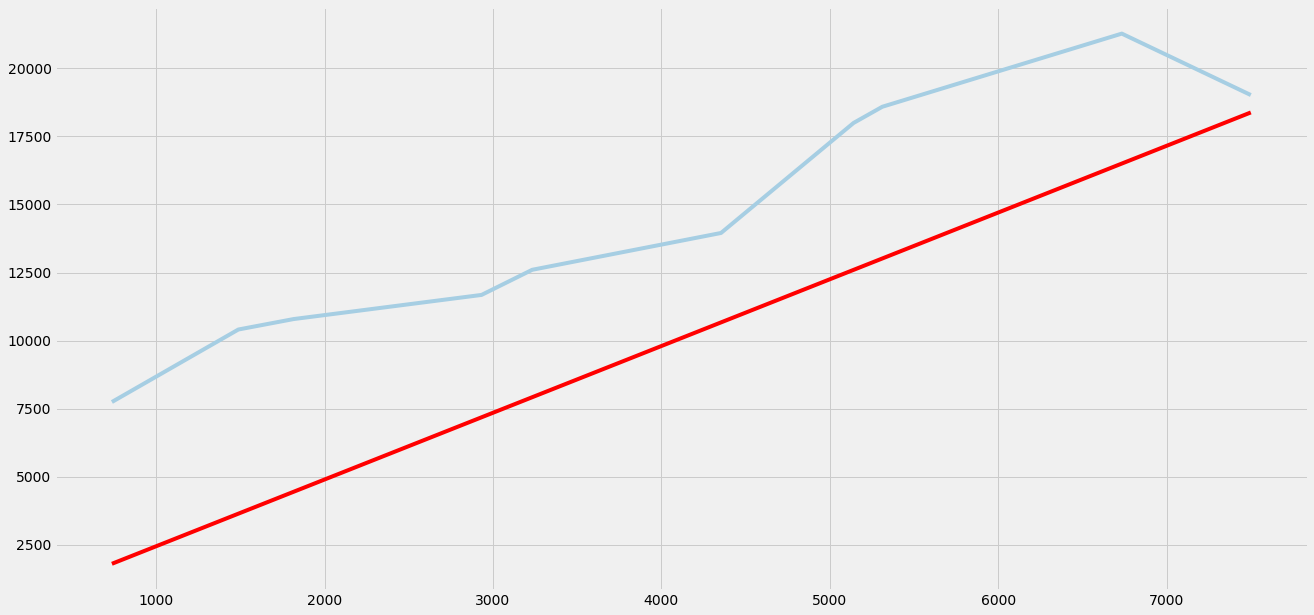

In [43]:
# The incremental gain is the cumulative effect of treating more customers

ATE_groups = ATE_groups[::-1] # reverse vector for plotting
plt.plot((np.cumsum(n_treated_groups)), (np.cumsum(np.array(n_treated_groups['treatment'])*(ATE_groups))))

# Under random targeting, the treatment effect for each group is the same as the overall treatment effect

ATE_conversion = np.mean(train.query('treatment_numeric==1')['spending10days']) - np.mean(train.query('treatment_numeric==0')['spending10days'])
plt.plot(np.cumsum(n_treated_groups), np.cumsum(ATE_conversion*n_treated_groups['treatment'])
, color='red');

# Bonus: Double-robust transformed outcome 

In [44]:
treatment_model = pickle.loads(treatment_LM) # load model from earlier 
treatment_group=pd.DataFrame(index=train.query('treatment_numeric==1').index) #create data frame to ensure indexing is correct for merging of the dat
treatment_group['reg_treatment'] = treatment_model.predict(train.query('treatment_numeric==1')[X]) #predictions for training data of this particular model (treatment group)
reg_treatment_fulltrain = treatment_model.predict(train[X]) # predictions on full training set

# repeat for control group
control_model = pickle.loads(control_LM)
control_group=pd.DataFrame(index=train.query('treatment_numeric==0').index)
control_group['reg_control'] = control_model.predict(train.query('treatment_numeric==0')[X]) 
reg_control_fulltrain = control_model.predict(train[X]) 

# save in a dataframe to ensure all calculations are correct (observation for observation) and the same length (=# training set observations)
DRTO= pd.DataFrame(index=train.index) 
DRTO= DRTO.merge(treatment_group['reg_treatment'], left_index=True, right_index=True, how="outer")
DRTO= DRTO.merge(control_group['reg_control'], left_index=True, right_index=True, how="outer")
DRTO = DRTO.fillna(0) 
DRTO

,reg_treatment,reg_control
0,13.125869,0.000000
1,15.982663,0.000000
2,13.125869,0.000000
3,11.242042,0.000000
5,11.242042,0.000000
...,...,...
59995,0.000000,10.922743
59996,0.000000,11.927633
59997,0.000000,13.546622
59998,0.000000,7.998378


In [45]:
# The transformed outcome has the same expected value as the ATE, but more variance

train['spending_DRTO'] = reg_treatment_fulltrain - reg_control_fulltrain + (train['spending10days']-DRTO['reg_treatment'])*train['treatment_numeric']/0.5 - train['treatment_numeric'].apply(lambda x: 1 - x)*(train['spending10days']-DRTO['reg_control'])
np.mean(train['spending_DRTO']) 

2.4066962665137157

# Transformed outcome regression

In [46]:
regressor.fit(train[X], train['spending_DRTO'])
pred['reg_DRTO']= regressor.predict(test[X]) # prediction on the test set
np.mean(pred['reg_DRTO'])

2.407352404723295